### Just imports

In [1]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
%matplotlib inline

# Задача 3
Ваша основная цель – научиться рекомендовать пользователям фильмы так, чтобы они им нравились.

In [2]:
# Лайки
train_likes_df = pd.read_csv('train_likes.csv')
# Время и каналы
schedule_df = pd.read_csv('schedule.csv')

In [3]:
# Фичи
with open('items.json') as f:
    items_dicts = json.load(f)

In [4]:
# Преобразуем фичи в {id: features} из [{},{}]
features = {}
for item in items_dicts:
    features_item = item.copy()
    del features_item['id']
    features[item['id']] = features_item

In [5]:
# Оставим только те лайки, о которых у нас есть информация (фичи)
train_likes_df = train_likes_df[train_likes_df.item_id.isin(features.keys())]
train_likes_df = train_likes_df[train_likes_df.item_id.isin(schedule_df.item_id)]
schedule_df = schedule_df[schedule_df.item_id.isin(train_likes_df.item_id)]

In [6]:
# Делаем словарь id_channel: бинарная нумерация
# Бинарная, потому что мы используем random_forest и если мы оставим просто нумерацию
# То он будет говорить >номера_канала <номера_канала
# А это бессмыслено
max_id = max(enumerate(set(schedule_df.channel)))[0]
channels_to_id = {}
for a,b in enumerate(set(schedule_df.channel)):
    channels_to_id[b] = a/max_id

In [7]:
# Посмотрим, что у нас есть.
schedule_df.head()

,time_end,time_start,item_id,channel
0,1.457357e+09,1.457354e+09,84868d868783ee3a41b963a2fb2629ec,02522a2b2726fb0a03bb19f2d8d9524d
1,1.457360e+09,1.457357e+09,84868d868783ee3a41b963a2fb2629ec,02522a2b2726fb0a03bb19f2d8d9524d
2,1.457371e+09,1.457369e+09,574629dcccbf0f871e9eec4ef14ff270,02522a2b2726fb0a03bb19f2d8d9524d
4,1.458465e+09,1.458462e+09,6d38003a9c000dd30e05edad1559b711,43baa6762fa81bb43b39c62553b2970d
5,1.457303e+09,1.457301e+09,574629dcccbf0f871e9eec4ef14ff270,7f1de29e6da19d22b51c68001e7e0e54


In [8]:
# Посмотрим, что у нас есть.
train_likes_df.head()

,user_id,item_id,channel,time
1,71a7f1d1be96603971ba66e4a17e845c,5edaf734b432e5cc954a10b59cb97e70,ec5decca5ed3d6b8079e2e7e7bacc9f2,1.390459e+09
3,5d9db6ab742755197343505bccfad516,aa5f2ca699da42e467e550f9f071fb3f,98f13708210194c475687be6106a3b84,1.391053e+09
5,64f9455a021ac68be70548767bc0fe84,e1cdbda92a8167c8a6c994872fd32b3e,1f0e3dad99908345f7439f8ffabdffc4,1.392539e+09
6,70a2805f307f49ec42d4309190daa587,e1cdbda92a8167c8a6c994872fd32b3e,5ef059938ba799aaa845e1c2e8a762bd,1.392611e+09
7,560a8a1743aea7f6cbb63b315172b2ab,0ccd2d96eb4b393ecb8cf4e55a6544b6,98f13708210194c475687be6106a3b84,1.392958e+09


# Метрика
Самое важно, что нам нужно в первую очередь - это метрика, а то не понятно, что оптимизировать.

Не знаю на сколько это плохо брать чужие реализации, но раз мы питонисты...
Реализация взята [тут](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py)

In [9]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [10]:
# Тут мы делаем словарь {id_film: пользователи, которые его лайкают}
items = dict()
a = 0
b = len(set(train_likes_df.item_id.values))

for _id in set(train_likes_df.item_id.values):
    if a % 1000 == 0: print(a,b)
    a+=1
    items[_id] = set(train_likes_df[train_likes_df.item_id == _id].user_id.values)

0 11623
1000 11623
2000 11623
3000 11623
4000 11623
5000 11623
6000 11623
7000 11623
8000 11623
9000 11623
10000 11623
11000 11623


In [11]:
# Это матрица схожести, основанная на словаре сверху
# Она нам нужна, чтобы учитывать других пользователей для рекомендации
class OtiaiMatrix():
    def __init__(self, items):
        self.items = items
  
    def __getitem__(self, keys):
        a = self.items[keys[0]]
        b = self.items[keys[1]]
        if sqrt(len(a)*len(b)) != 0:
            return len(a & b)/sqrt(len(a)*len(b))
        else:
            return len(a & b)

In [12]:
# Создаём матрицу.
matrix = OtiaiMatrix(items)

In [13]:
# Из названий, думаю, ясно
# Словари - потому что нам нужно рекомендовать пользователю очень быстро, а
# Pandas не очень быстрый =)
time_end = dict(zip(schedule_df.item_id.values, schedule_df.time_end.values))
time_start = dict(zip(schedule_df.item_id.values, schedule_df.time_start.values))
item_chennel = dict(zip(schedule_df.item_id.values, schedule_df.channel.values))

In [14]:
# Жанр
# Год
# Кол-во фичей
# Продолжительность
# Время, когда фильм заканчивается
# Время, когда фильм начинается
# Канал


def id_to_feature(_id):
    '''Фичи для каждого фильма по отдельности'''
    feature = features[_id]
    return [feature['genre'], feature['year'], feature['duration'], 
            len(feature), max(feature.values()),
            time_end[_id], time_start[_id], channels_to_id[item_chennel[_id]]]

In [15]:
# Коэффициент схожести
# Длина пересечения фичей
# Длина исключения фичей

def ids_to_feature(row):
    '''Фичи для группы фильмов'''
    global features
    
    features_out = []
    otiai = []
    
    for _id in row[:-1]:
        otiai.append(matrix[_id, row[-1]])
        features_out.append(len(set(features[_id]) & set(features[row[-1]])))
        features_out.append(len(set(features[_id]) ^ set(features[row[-1]])))
    
    features_out += otiai
    return features_out

In [16]:
# Эта функция просто обёртка для двух функций выше
def get_features(row):
    '''Get features for row'''
    features_id = []
    
    for _id in row:
        features_id += id_to_feature(_id)
    
    features_row = ids_to_feature(row)
    return features_id + features_row

In [17]:
import random


def create_data(n: int=4, test_len: int=10):
    global train_likes_df, schedule_df, features
    print('Get ids')
    # Возьмём все id людей, которые пролайкали минимум n фильмов
    ids = [i for i, count in Counter(train_likes_df.user_id).most_common() if count >= n]
    
    print('Get films ids')
    # Возьмём эти залайканные фильмы отсортерованные по времени
    train_likes_df_local = train_likes_df[train_likes_df.user_id.isin(ids)].sort_values(['time'])
    films_ids = set(train_likes_df_local.item_id) & set(features.keys())
    
    print('Start generate data')
    # Начинаем генерировать данные:
    train_data = []
    print('Gen last n films')
    # Берём n последних фильмов для каждого пользователя
    for _id in ids:
        train_data.append(list(train_likes_df_local[train_likes_df_local.user_id == _id].item_id.values))
    
    random.shuffle(train_data)
    samples = int(len(train_data)/100*test_len)*2 #потому что сгенерированной рандомной даты столько же
    test = train_data[:samples]
    train_data = train_data[samples:]
    
    # добавляем к ним 1 - это значит, что данные реальные
    # А не сгенерированные
    train_data = [i + [1] for i in train_data]
    print('Create random data')
    # Сгенерируем ложные данные для тренировки
    # Которые пользователю 'не понравились'
    for i in range(0, len(train_data)):
        films = []
        for i in range(0,n):
            films.append(random.choice(list(films_ids)))
        train_data.append(films + [0])
    train = train_data
    print(len(test), len(train))
    
    print('Get features for train')
    # Теперь превратим сборище id в фичи для бинарного классификатора с помощью специальной функции
    for row in train:
        new_row = []
        row_state = row[-1]
        new_row += get_features(row[-n-1:-1])
        train[train.index(row)] = new_row + [row_state]
    
    random.shuffle(train)
    train_X, train_y = [i[:-1] for i in train], [i[-1] for i in train]
    
    print('Get features for test')
    # Для теста мы будем возращать все фильмы, которые понравились пользователю, как y
    # И как x n-1 id последних фильмов
    for row in test:
        new_row = []
        row_state = row[:-n] + [row[-1]]
        new_row = row[-n:-1]
        test[test.index(row)] = new_row + [row_state]
    random.shuffle(test)
    
    test_X, test_y = [i[:-1] for i in test], [i[-1] for i in test]
    
    return train_X, train_y, test_X, test_y

In [18]:
# Генерируем данные для обучения
train_X, train_y, test_X, test_y = create_data(4, 20)

Get ids
Get films ids
Start generate data
Gen last n films
Create random data
1090 3270
Get features for train
Get features for test


In [19]:
# Тренеруем модель на данных
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
forest.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
def predict_id(films):
    """Принимает n-1 предыдущих фильмов - возращает отсортерованные по вероятности фильмы"""
    global forest
    to_predict = []
    # Берём все id фильмов
    films_ids = set(train_likes_df.item_id) & set(features.keys())
    # Для каждого id берём фичи совместно с тем, что нам уже пришло и кладём в массив
    for film in films_ids:
        to_predict.append(get_features(films + [film]))
    # Предсказываем и берём вероятность того, что нам понравится
    predicted = list(map(lambda a: a[1], forest.predict_proba(to_predict)))
    # Сопоставляем id фильмов с предсказаниями
    predicted = dict(zip(films_ids, predicted))
    # Counter для удобства
    predicted = Counter(predicted)
    # Выдаём id отсортерованные по вероятности
    return [i[0] for i in predicted.most_common()]

In [27]:
# Сюда будем класть значения
apks = []
a = 0
b = len(test_y)
# Пройдёмся по всей выборке
for films, answer in zip(test_X, test_y):
    a+=1
    # На каждом 10-том будем выдавать статус
    if a%10 == 0: print(a,'/',b,np.mean(apks))
    # И сохраняем apk
    apks.append(apk(answer, predict_id(films), len(answer)))

10 / 1090 0.209813797314
20 / 1090 0.328205758587
30 / 1090 0.308363758223
40 / 1090 0.320656398291
50 / 1090 0.341556984513
60 / 1090 0.322312569135
70 / 1090 0.308804875327
80 / 1090 0.298728554404
90 / 1090 0.287287903999
100 / 1090 0.269785321825
110 / 1090 0.283963344171
120 / 1090 0.304809799998
130 / 1090 0.288644661047
140 / 1090 0.281058622835
150 / 1090 0.269007246452
160 / 1090 0.269832764143
170 / 1090 0.257927208385
180 / 1090 0.273545800095
190 / 1090 0.284236892217
200 / 1090 0.276873159079
210 / 1090 0.282633135519
220 / 1090 0.282376881177
230 / 1090 0.280720448777
240 / 1090 0.277374763801
250 / 1090 0.276051490245
260 / 1090 0.273085690423
270 / 1090 0.269767007928
280 / 1090 0.267726724587
290 / 1090 0.260323297327
300 / 1090 0.262389703555
310 / 1090 0.258223524214
320 / 1090 0.259846164925
330 / 1090 0.265288979554
340 / 1090 0.271160028885
350 / 1090 0.276095753504
360 / 1090 0.278828097309
370 / 1090 0.280128160359
380 / 1090 0.277149932476
390 / 1090 0.27762571

In [22]:
# Посмотрим MAP@K
np.mean(apks)

0.39579879212983188

<Container object of 1090 artists>

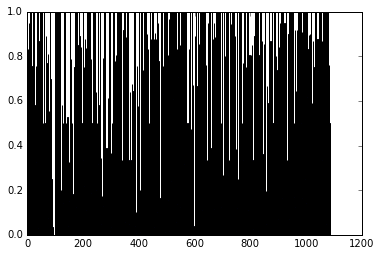

In [23]:
# А теперь вместо среднего, посмотрим, 'пульс' предсказания
# AP@K по y оси
plt.bar(range(len(apks)), apks)

Эта картинка означает, что некоторым пользователям мы порекомендуем очень хорошо, а некоторым так себе.
Чем меньше спусков на графике тем лучше.

Теперь напишем функции для рекомендации.

In [24]:
# Возьмём все id людей, которые пролайкали минимум n фильмов
ids = [i for i, count in Counter(train_likes_df.user_id).most_common() if count >= 3]
# Возьмём эти залайканные фильмы отсортерованные по времени
train_likes_df_local = train_likes_df[train_likes_df.user_id.isin(ids)].sort_values(['time'])
films_ids = set(train_likes_df_local.item_id) & set(features.keys())
    
def recomend(user, film = None, n = 3):
    '''На входе принемаем id пользоваетля и текущий фильм.'''
    if user not in ids:
        return [i[0] for i in Counter(train_likes_df.item_id.values).most_common(n)]
    
    if not film:
        train_data = list(train_likes_df_local[train_likes_df_local.user_id == user].item_id.values)[-3:]
    else:
        train_data = list(train_likes_df_local[train_likes_df_local.user_id == user].item_id.values)[-2:]
        train_data.append(film)
    return predict_id(train_data)[:n]
    
    

In [25]:
# Пользователь смотрит фильм, рекомендуем с учетом фильма
recomend('1e774f168d8523095b6a1b31e7c31ff4', '6b295d5430ca0c223ac21057336f9e1d', 3)

['e803ab6454973242a1cf4043cb947531',
 '5527fe23e4b1ebce7307d0528c0f38df',
 'b513db7287f1b585a7cffc82251e0219']

In [26]:
# Пользователя нет, фильма нет =)
recomend('1e774f168d8523095b6a1b31e7c31ff4')

['1effb78d80bd8fc7d4cab1161a34b255',
 '3b20b13ad11626b0205e0230d62ba57f',
 '6522dece07a6885ff28e11e0f3babf8b']